<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

In [6]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

# Layer properties (example values)
layer_thicknesses = np.array([1000, 2000, 3000])  # in meters
rock_densities = np.array([2700, 2700, 2700])  # in kg/m^3
porosities = np.array([0.0, 0.0, 0.0])

# Calculate lithostatic pressure at depth h
def lithostatic_pressure_onshore(h):
    layer_depths = np.cumsum(layer_thicknesses)
    pressure = 0
    for thickness, density, porosity in zip(layer_thicknesses, rock_densities, porosities):
        if h > 0:
            effective_thickness = min(thickness, h)
            pressure += g * density * (1 - porosity) * effective_thickness
            h -= thickness
        else:
            break
    return pressure / 1e6  # Convert Pa to MPa

def lithostatic_pressure_offshore(h):
    if h <= water_depth:
        return g * rho_sea * h / 1e6  # Hydrostatic pressure from water
    else:
        pressure = g * rho_sea * water_depth  # Hydrostatic pressure from water column
        h -= water_depth
        return (pressure + lithostatic_pressure_onshore(h) * 1e6) / 1e6  # Add lithostatic pressure from sediments

# Example usage
depth = 4000  # depth in meters
print("Onshore Lithostatic Pressure at 1500 m:", lithostatic_pressure_onshore(depth), "MPa")
print("Offshore Lithostatic Pressure at 1500 m:", lithostatic_pressure_offshore(depth), "MPa")

Onshore Lithostatic Pressure at 1500 m: 105.948 MPa
Offshore Lithostatic Pressure at 1500 m: 90.252 MPa


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

In [ ]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

In [7]:
def hydrostatic_pressures(depths):

    GRAVITY = 9.81
    DENSITY_SEA_WATER = 1100  # Density of sea water (kg/m^3)

    """Calculate hydrostatic pressures for an array of depths."""

    pressures = [quad(lambda z: DENSITY_SEA_WATER * GRAVITY, 0, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa
    return pressures

In [15]:
def lithostatic_pressures(layer_thicknesses, rock_densities, porosities):

    from scipy.integrate import quad
    GRAVITY = 9.81  # Acceleration due to gravity (m/s^2)
    DENSITY_SEA_WATER = 1100  # Density of sea water (kg/m^3)

    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    layer_depths = np.cumsum(layer_thicknesses)
    print("Layer Depths:", layer_depths, "Number of Layers:", len(layer_depths))

    def lithostatic_pressure_calculation(rho_rock, porosity, upper_bound, lower_bound):
        rho_effective = (1 - porosity) * rho_rock + porosity * DENSITY_SEA_WATER
        print(f"Effective Density: {rho_effective}, Porosity: {porosity}, Depth Range: {lower_bound}-{upper_bound} m")
        return quad(lambda z: rho_effective * GRAVITY, lower_bound, upper_bound)[0] / 1e6

    previous_layer_depth = 0
    cumulative_pressure = 0
    pressures = []

    for layer_depth, rho_rock, porosity in zip(layer_depths, rock_densities, porosities):
        pressure = lithostatic_pressure_calculation(rho_rock, porosity, layer_depth, previous_layer_depth)
        cumulative_pressure += pressure
        pressures.append(cumulative_pressure)
        previous_layer_depth = layer_depth

    return pressures

In [ ]:
# Example usage:
# Layer properties
layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

pressures_lit = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
layer_depths = np.cumsum(layer_thicknesses/1000)
layer_depths = np.insert(layer_depths, 0, 0)
pressures_lit = np.insert(pressures_lit, 0, 0)

print("Cumulative Pressures Lith:", pressures_lit )


Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Cumulative Pressures Lith: [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


In [ ]:
depths = np.linspace(0, 6000, 6)  # 0 to 5 km
pressures_hydrostatic = hydrostatic_pressures(depths)
depths = depths/1000
print("Hydrostatic pressures:", pressures_hydrostatic)

Hydrostatic pressures: [0.0, 12.9492, 25.8984, 38.8476, 51.7968, 64.746]


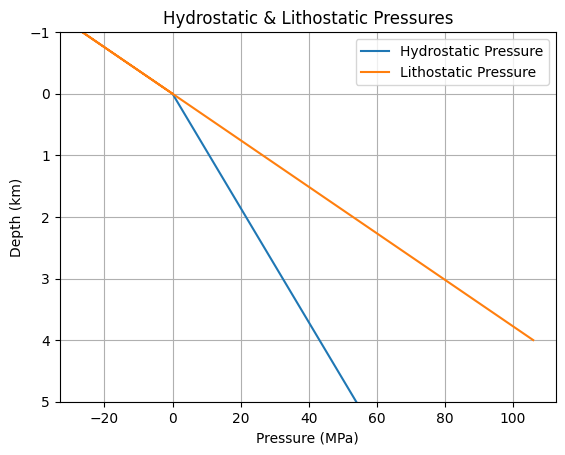

In [ ]:
# Offshore plot
ax1 = plt.subplot(1, 1, 1)

plt.plot(pressures_hydrostatic, depths, label='Hydrostatic Pressure')
plt.plot(pressures_lit, layer_depths, label='Lithostatic Pressure')
plt.title('Hydrostatic & Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
# plt.xlim(0, 60)
plt.ylim(-1, 5)
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)


In [9]:
# Example usage:
# Layer properties
layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

pressures_lit = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
layer_depths = np.cumsum(layer_thicknesses/1000)
layer_depths = np.insert(layer_depths, 0, 0)
pressures_lit = np.insert(pressures_lit, 0, 0)

print("Cumulative Pressures Lith:", pressures_lit )


Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Cumulative Pressures Lith: [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


In [ ]:
# depths = np.linspace(0, 6000, 6)  # 0 to 5 km
# # pressures_hydrostatic = hydrostatic_pressures(depths)
# # depths = depths/1000
# # print("Hydrostatic pressures:", pressures_hydrostatic)

In [25]:
def pressure(pressure_types):
    # Hydrostatic pressure
    depths = np.linspace(-1000, 6000, 6)

    # Lithostatic pressure
    layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
    rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
    porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(depths)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_thicknesses, rock_densities, porosities)
        layer_depths = np.cumsum(layer_thicknesses)
        layer_depths = np.insert(layer_depths, 0, 0)
        pressures_lit = np.insert(lith_pressures, 0, 0)
        print("Lithostatic pressures (MPa):", pressures_lit)


      # Plotting
    plt.figure(figsize=(6, 12))

    ax1 = plt.subplot(1, 1, 1)

    plt.plot(pressures_hydrostatic, depths, label='Hydrostatic Pressure')
    plt.plot(pressures_lit, layer_depths, label='Lithostatic Pressure')
    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    # plt.xlim(0, 60)
    plt.ylim(-1, 5)
    ax1.invert_yaxis()  # Invert the y-axis for offshore plot
    plt.legend()
    plt.grid(True)


pressure(['hydrostatic', 'lithostatic'])

Hydrostatic pressures (MPa): [0.0, 12.9492, 25.8984, 38.8476, 51.7968, 64.746]
Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
Lithostatic pressures (MPa): [  0.    -26.487   0.     26.487  52.974  79.461 105.948]


### Final version with plot

In [32]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

Hydrostatic pressures (MPa): [0.0, 10.791, 21.582, 32.373, 43.164, 53.955]
Lithostatic pressures (MPa): [  0.     26.487  52.974  79.461 105.948 132.435 158.922]


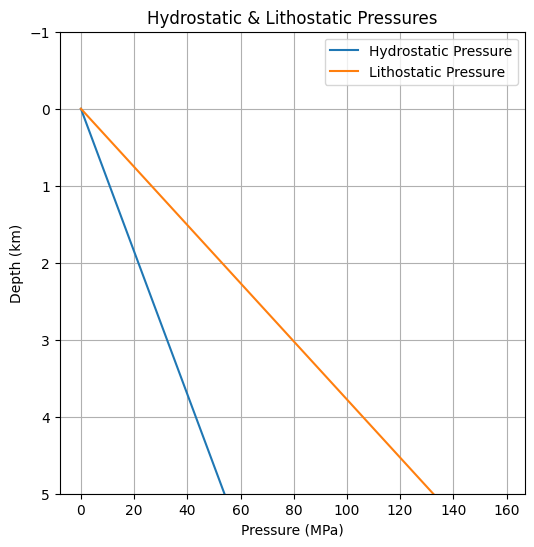

In [41]:
def hydrostatic_pressures(depths, rho_sea=1100):
    """Calculate hydrostatic pressures for an array of depths."""
    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [rho_sea * g * depth / 1e6 for depth in depths]  # Convert Pa to MPa
    return pressures

def lithostatic_pressures(layer_thicknesses, rock_densities, porosities, water_depth):
    """Calculate lithostatic pressures for a stack of layers."""
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0
    for thickness, density, porosity in zip(layer_thicknesses, rock_densities, porosities):
        effective_density = density * (1 - porosity) + rho_sea*porosity

        if layer_thicknesses[0]<=water_depth:
          pressure_increment = effective_density * g * thickness
          total_depth += thickness
          total_pressure += pressure_increment
          pressures.append(total_pressure / 1e6)  # Convert Pa to MPa

        else:
          pressure_increment = effective_density * g * thickness
          total_depth += thickness
          water_pressure = g * rho_sea * water_depth
          total_pressure += pressure_increment
          total_pressure += water_pressure
          pressures.append((water_pressure + total_pressure) / 1e6)  # Convert Pa to MPa

    return pressures


def pressure(pressure_types):
    # Hydrostatic pressure
    depths = np.linspace(0, 5000, 6)  # depths in meters

    # Lithostatic pressure
    layer_thicknesses = np.array([1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
    rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
    porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(depths)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_thicknesses, rock_densities, porosities, water_depth=0)
        layer_depths = np.cumsum(layer_thicknesses)
        layer_depths = np.insert(layer_depths, 0, 0)
        pressures_lit = np.insert(lith_pressures, 0, 0)
        print("Lithostatic pressures (MPa):", pressures_lit)

    # Plotting
    plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(1, 1, 1)

    if 'hydrostatic' in pressure_types:
        plt.plot(pressures_hydrostatic, depths / 1000, label='Hydrostatic Pressure')  # Convert depths to km
    if 'lithostatic' in pressure_types:
        plt.plot(pressures_lit, layer_depths / 1000, label='Lithostatic Pressure')  # Convert layer depths to km

    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    plt.ylim(5, -1)  # Set limits after converting depths to km
    plt.legend()
    plt.grid(True)
    plt.show()

pressure(['hydrostatic', 'lithostatic'])

In [ ]:
# Plotting
plt.figure(figsize=(6, 12))

# Offshore plot
ax1 = plt.subplot(2, 1, 1)
plt.plot(hydrostatic_pressures_offshore, depths_offshore, label='Hydrostatic Pressure Offshore')
plt.plot(hydrostatic_pressures_onshore, depths_onshore, label='Hydrostatic Pressure Onshore')
plt.title('Offshore Hydrostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
plt.xlim(0, 60)
plt.ylim(-1, 5)
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)


In [ ]:
def pressure(pressure_type):

  if 'hydrostatic' in pressure_type:
    hydrostatic_pressures(depths)

  elif 'lithostatic' in pressure_type:




In [ ]:
pressure_type = "hydrostatic"  # or "lithostatic"

Layer Depths: [-1000     0  1000  2000  3000  4000] Number of Layers: 6
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0--1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: -1000-0 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 0-1000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 1000-2000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 2000-3000 m
Effective Density: 2700.0, Porosity: 0.0, Depth Range: 3000-4000 m
[-15.695999999999996, 21.582, 58.86, 96.138, 133.416, 170.694]


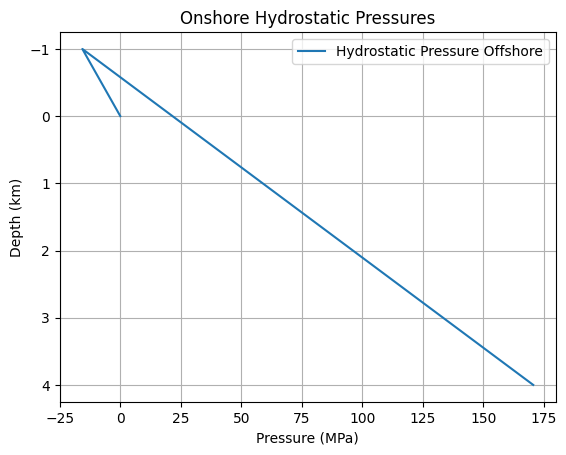

In [ ]:
# Constants
GRAVITY = 9.81  # gravitational acceleration in m/s^2
DENSITY_SEA_WATER = 1100  # density of sea water in kg/m^3

# Layer properties
layer_thicknesses = np.array([-1000, 1000, 1000, 1000, 1000, 1000])  # thickness of each layer in meters
rock_densities = np.array([2700, 2700, 2700, 2700, 2700, 2700])  # density of each rock layer in kg/m^3
porosities = np.array([0., 0., 0., 0., 0., 0.])  # porosity of each layer

# Calculate cumulative depths of each layer
layer_depths = np.cumsum(layer_thicknesses)
print("Layer Depths:", layer_depths, "Number of Layers:", len(layer_depths))

def lithostatic_pressure(layer_thicknesses, rho_rock, porosity, upper_bound, lower_bound):
    """
    Calculate lithostatic pressure between two depths for a given rock density and porosity.

    Parameters:
    - rho_rock: Rock density (kg/m^3)
    - porosity: Porosity of the layer (fraction)
    - upper_bound: Upper depth boundary (m)
    - lower_bound: Lower depth boundary (m)

    Returns:
    - Pressure in MPa
    """

    rho_effective = (1 - porosity) * rho_rock + porosity * DENSITY_SEA_WATER
    print(f"Effective Density: {rho_effective}, Porosity: {porosity}, Depth Range: {lower_bound}-{upper_bound} m")
    # Calculate pressure and convert from Pa to MPa

    if layer_thicknesses[0] >= 0: # Onshore
      return quad(lambda z: rho_effective * GRAVITY, lower_bound, upper_bound)[0] / 1e6

    else: # Offshore
      return ((DENSITY_SEA_WATER * GRAVITY * water_depth) + quad(lambda z: rho_effective * GRAVITY, lower_bound, upper_bound)[0]) / 1e6



# Initialize variables for tracking depth and cumulative pressure
previous_layer_depth = 0
cumulative_pressure = 0
pressures = []

# Calculate lithostatic pressure for each layer
for layer_depth, rho_rock, porosity in zip(layer_depths, rock_densities, porosities):
    pressure = lithostatic_pressure(layer_thicknesses, rho_rock, porosity, layer_depth, previous_layer_depth)
    cumulative_pressure += pressure
    pressures.append(cumulative_pressure)
    previous_layer_depth = layer_depth

# Output the calculated pressures
print(pressures)

In [ ]:
# Onshore plot
ax1 = plt.subplot(1, 1, 1)

layer_depths = np.cumsum(layer_thicknesses) / 1000
layer_depths = np.insert(layer_depths, 0, 0)
pressures = np.insert(pressures, 0, 0)

plt.plot(pressures, layer_depths, label='Hydrostatic Pressure Offshore')
plt.title('Onshore Hydrostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
# plt.xlim(0, 60)
# plt.ylim(0, 5)
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)

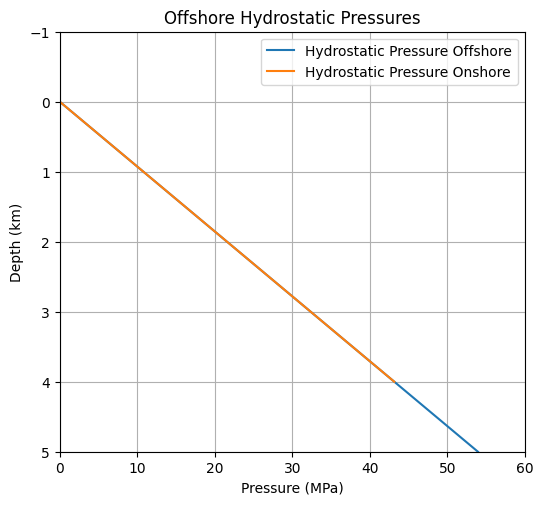

In [ ]:
# Plotting
plt.figure(figsize=(6, 12))

# Offshore plot
ax1 = plt.subplot(2, 1, 1)
plt.plot(hydrostatic_pressures_offshore, depths_offshore, label='Hydrostatic Pressure Offshore')
plt.plot(hydrostatic_pressures_onshore, depths_onshore, label='Hydrostatic Pressure Onshore')
plt.title('Offshore Hydrostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
plt.xlim(0, 60)
plt.ylim(-1, 5)
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)


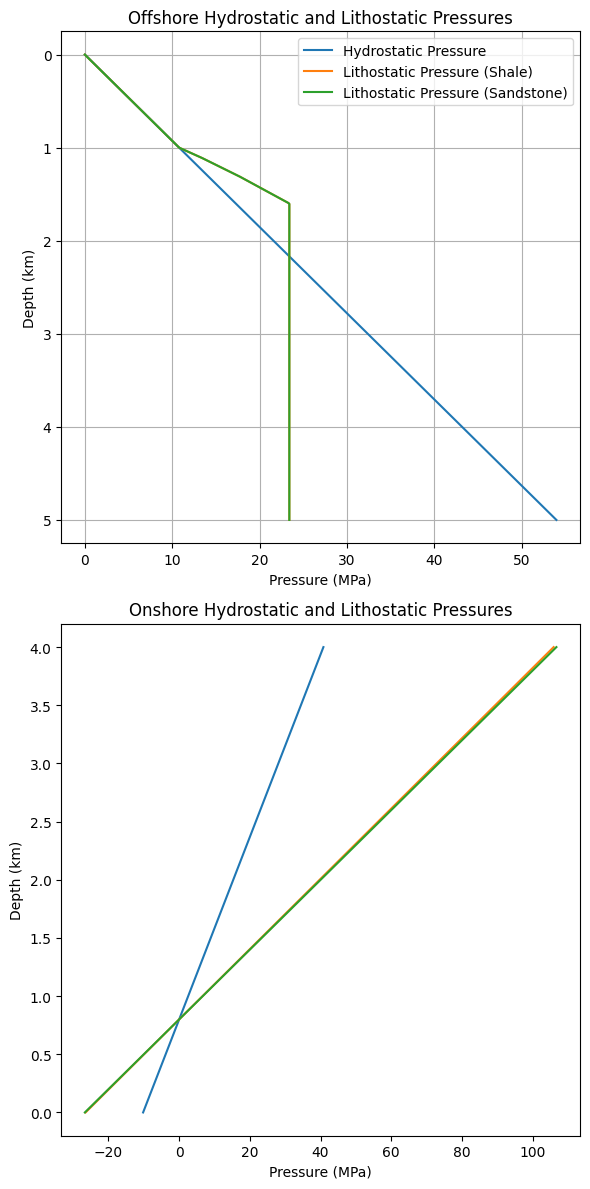

In [ ]:
plt.xlim(0, 60)
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

# Layer properties (example values)
layer_thicknesses = np.array([100, 200, 300])  # in meters
rock_densities = np.array([2700, 2600, 2500])  # in kg/m^3
porosities = np.array([0.1, 0.15, 0.2])

# Define pressure calculation functions
def hydrostatic_pressure(depth, rho):
    """Calculate hydrostatic pressure at a given depth using integration."""
    return quad(lambda z: rho * g, 0, depth)[0] / 1e6  # Convert Pa to MPa

def lithostatic_pressure_onshore(h):
    layer_depths = np.cumsum(layer_thicknesses)
    pressure = 0
    for thickness, density, porosity in zip(layer_thicknesses, rock_densities, porosities):
        if h > 0:
            effective_thickness = min(thickness, h)
            pressure += g * density * (1 - porosity) * effective_thickness
            h -= thickness
        else:
            break
    return pressure / 1e6  # Convert Pa to MPa

def lithostatic_pressure_offshore(h):
    if h <= water_depth:
        return g * rho_sea * h / 1e6  # Hydrostatic pressure from water
    else:
        pressure = g * rho_sea * water_depth  # Hydrostatic pressure from water column
        h -= water_depth
        return (pressure + lithostatic_pressure_onshore(h) * 1e6) / 1e6  # Add lithostatic pressure from sediments

# Depth ranges for the plots (in kilometers)
depths_offshore = np.linspace(0, 5, 500)  # 0 to 5 km
depths_onshore = np.linspace(0, 4, 500)  # 0 to 4 km

# Calculate pressures
hydrostatic_pressures_offshore = [hydrostatic_pressure(depth * 1000, rho_sea) for depth in depths_offshore]
lithostatic_pressures_shale_offshore = [lithostatic_pressure_offshore(depth * 1000) for depth in depths_offshore]
lithostatic_pressures_sandstone_offshore = [lithostatic_pressure_offshore(depth * 1000) for depth in depths_offshore]
lithostatic_pressures_onshore = [lithostatic_pressure_onshore(depth * 1000) for depth in depths_onshore]

# Plotting
plt.figure(figsize=(6, 12))

# Offshore plot
ax1 = plt.subplot(2, 1, 1)
plt.plot(hydrostatic_pressures_offshore, depths_offshore, label='Hydrostatic Pressure')
plt.plot(lithostatic_pressures_shale_offshore, depths_offshore, label='Lithostatic Pressure (Shale)')
plt.plot(lithostatic_pressures_sandstone_offshore, depths_offshore, label='Lithostatic Pressure (Sandstone)')
plt.title('Offshore Hydrostatic and Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)

# Onshore plot
ax2 = plt.subplot(2, 1, 2)
plt.plot(hydrostatic_pressures_onshore, depths_onshore, label='Hydrostatic Pressure')
plt.plot(lithostatic_pressures_shale_onshore, depths_onshore, label='Lithostatic Pressure (Shale)')
plt.plot(lithostatic_pressures_sandstone_onshore, depths_onshore, label='Lithostatic Pressure (Sandstone)')
plt.title('Onshore Hydrostatic and Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Pressure (MPa)')

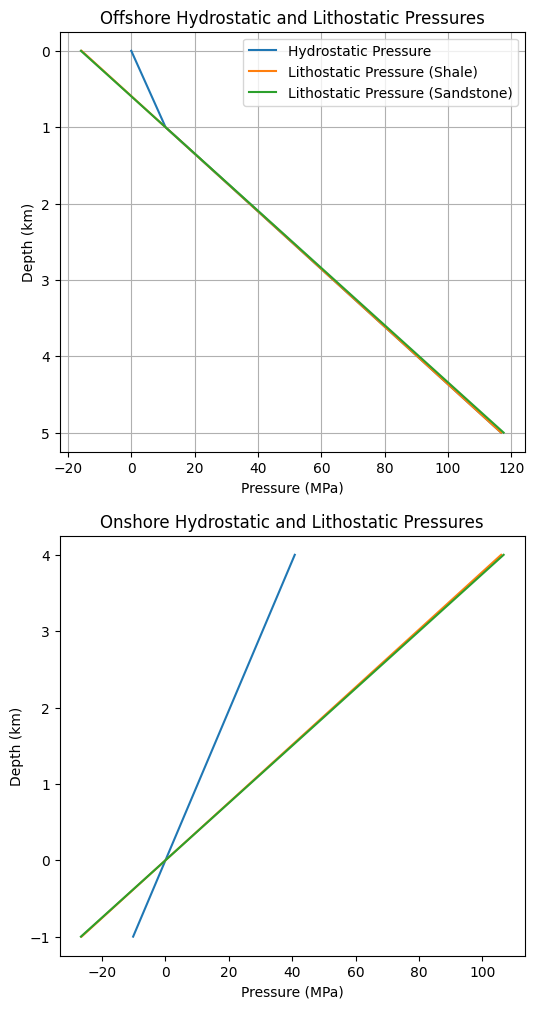

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

# Define pressure calculation functions
def hydrostatic_pressure(depth, rho):
    """Calculate hydrostatic pressure at a given depth using integration."""
    return quad(lambda z: rho * g, 0, depth)[0] / 1e6  # Convert Pa to MPa

def lithostatic_pressure(depth, rho):
    """Calculate lithostatic pressure at a given depth using integration."""
    return quad(lambda z: rho * g, 0, depth)[0] / 1e6  # Convert Pa to MPa

# Depth ranges for the plots (in kilometers)
depths_offshore = np.linspace(0, 5, 500)  # 0 to 5 km
depths_onshore = np.linspace(-1, 4, 500)  # -1 to 4 km

# Calculate pressures
hydrostatic_pressures_offshore = [
    hydrostatic_pressure(depth * 1000, rho_sea) if depth <= water_depth / 1000
    else hydrostatic_pressure(water_depth, rho_sea) + lithostatic_pressure((depth - water_depth / 1000) * 1000, rho_shale)
    for depth in depths_offshore
]
lithostatic_pressures_shale_offshore = [
    hydrostatic_pressure(water_depth, rho_sea) + lithostatic_pressure((depth - water_depth / 1000) * 1000, rho_shale)
    for depth in depths_offshore
]
lithostatic_pressures_sandstone_offshore = [
    hydrostatic_pressure(water_depth, rho_sea) + lithostatic_pressure((depth - water_depth / 1000) * 1000, rho_sandstone)
    for depth in depths_offshore
]

hydrostatic_pressures_onshore = [lithostatic_pressure(depth * 1000, rho_w) for depth in depths_onshore]
lithostatic_pressures_shale_onshore = [lithostatic_pressure(depth * 1000, rho_shale) for depth in depths_onshore]
lithostatic_pressures_sandstone_onshore = [lithostatic_pressure(depth * 1000, rho_sandstone) for depth in depths_onshore]

# Plotting
plt.figure(figsize=(6, 12))

# Offshore plot
ax1 = plt.subplot(2, 1, 1)
plt.plot(hydrostatic_pressures_offshore, depths_offshore, label='Hydrostatic Pressure')
plt.plot(lithostatic_pressures_shale_offshore, depths_offshore, label='Lithostatic Pressure (Shale)')
plt.plot(lithostatic_pressures_sandstone_offshore, depths_offshore, label='Lithostatic Pressure (Sandstone)')
plt.title('Offshore Hydrostatic and Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')
ax1.invert_yaxis()  # Invert the y-axis for offshore plot
plt.legend()
plt.grid(True)

# Onshore plot
ax2 = plt.subplot(2, 1, 2)
plt.plot(hydrostatic_pressures_onshore, depths_onshore, label='Hydrostatic Pressure')
plt.plot(lithostatic_pressures_shale_onshore, depths_onshore, label='Lithostatic Pressure (Shale)')
plt.plot(lithostatic_pressures_sandstone_onshore, depths_onshore, label='Lithostatic Pressure (Sandstone)')
plt.title('Onshore Hydrostatic and Lithostatic Pressures')
plt.ylabel('Depth (km)')
plt.xlabel('Pressure (MPa)')